In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, Point, MultiPoint, Polygon
import itertools
import warnings
warnings.filterwarnings("ignore")

#### Read In Datasets and Files

* am2015 is the AM dataframe that was created previously
* pm2015 is the PM dataframe that was created previously
* off2015 is the Off-Peak dataframe that was created previously
* track_miles is contains the track distance in miles between OD pairs
* mstns contains the station names and ID numbers

In [2]:
am2015 = pd.read_excel("../../Data/100_AM_Peak_Other_Regular_Riders.xlsx")
pm2015 = pd.read_excel("../../Data/200_PMPeak_Model_Long_file.xlsx")
off2015 = pd.read_excel("../../Data/300_OffPeak_Other_Regular_Riders.xlsx")
track_miles = pd.read_excel("../../Data/railOD_trackMiles_spring2022.xlsx", header=1, index_col=0)
mstns = pd.read_excel("../../Data/mstn_id_to_stn_name.xlsx")

#### AM Preprocessing

* Create a names column for the station names in mstns so that track_miles and the mstns can merge easily
* Format the track_miles into OD pairs
* Merge the station IDs into track_miles, drop unnecessary columns
* Create an OD pair column in the track_miles dataframe that can be used to merge track_miles and 2015 dataframes together
* Format the 2015 OD pair column into strings
* Subset am 2015 by the OD Pair column, auto travel time, auto travel time per mile and log auto travel time per mile columns
* Merge the track_miles and 2015 AM dataframes together by the od pairs columns

In [3]:
mstns.sort_values(by="PRIMARY_NAME_FY23", inplace=True)
mstns['track_miles_names'] = ['Addison Road', 'Anacostia', 'Archives', 'Arlington Cemetery', "",
       'Ballston-MU', 'Benning Road', 'Bethesda', 'Braddock Road',
       'Branch Ave', 'Brookland-CUA', 'Capitol Heights', 'Capitol South',
       'Cheverly', 'Clarendon', 'Cleveland Park', 'College Park-U of Md',
       'Columbia Heights', 'Congress Heights', 'Court House',
       'Crystal City', 'Deanwood', 'Largo Town Center', "", 'Dunn Loring', 'Dupont Circle',
       'East Falls Church', 'Eastern Market', 'Eisenhower Ave',
       'Farragut North', 'Farragut West', 'Federal Center SW',
       'Federal Triangle', 'Foggy Bottom-GWU', 'Forest Glen',
       'Fort Totten', 'Franconia-Springfield', 'Friendship Heights',
       'Gallery Place', 'Georgia Ave-Petworth', 'Glenmont', 'Greenbelt',
       'Greensboro', 'Grosvenor-Strathmore', "",'Huntington',"Prince George's Plaza", "",
       'Judiciary Square', 'King St-Old Town', "L'Enfant Plaza",
       'Landover',"", 'McLean', 'McPherson Square',
       'Medical Center', 'Metro Center', 'Minnesota Ave',
       'Morgan Boulevard', 'Mt Vernon Sq', 'Navy Yard-Ballpark',
       'Naylor Road', 'New Carrollton', 'NoMa-Gallaudet U','White Flint', 'Pentagon',
       'Pentagon City', 'Potomac Ave', "","",
       'Rhode Island Ave', 'Rockville',
       'Ronald Reagan Washington National Airport', 'Rosslyn',
       'Shady Grove', 'Shaw-Howard Univ', 'Silver Spring', 'Smithsonian',
       'Southern Ave', 'Spring Hill', 'Stadium-Armory', 'Suitland',
       'Takoma', 'Tenleytown-AU', 'Twinbrook', 'Tysons Corner',
       'U Street', 'Union Station', 'Van Dorn Street', 'Van Ness-UDC',
       'Vienna', 'Virginia Square-GMU', 'Waterfront', 'West Falls Church',
       'West Hyattsville', 'Wheaton',  'Wiehle',
       'Woodley Park']

In [4]:
track_miles = track_miles.stack().rename_axis(('O', 'D')).reset_index(name="track_miles")
track_miles.head()

,O,D,track_miles
0,Addison Road,Addison Road,0.10
1,Addison Road,Anacostia,10.35
2,Addison Road,Archives,8.31
3,Addison Road,Arlington Cemetery,11.39
4,Addison Road,Ballston-MU,14.27


In [5]:
track_miles2 = mstns.merge(track_miles, left_on ='track_miles_names' , right_on= 'O')
track_miles2 = mstns.merge(track_miles2, left_on ='track_miles_names' , right_on='D' )

In [6]:
track_miles2.drop(["PRIMARY_NAME_FY23_x", "PRIMARY_NAME_FY23_y", "track_miles_names_x", "track_miles_names_y"], axis=1, inplace=True)

In [7]:
track_miles2['pairs'] = track_miles2.apply(lambda x: str(x['ID_y'])+str(0)+str(x['ID_x']), axis=1)
track_miles2['ID1'] = track_miles2['ID_y'].replace('[A-Z]{4}_0', '', regex=True)
track_miles2['ID2'] = track_miles2['ID_x'].replace('[A-Z]{4}_0', '', regex=True)
track_miles2['ID1'] = track_miles2['ID1'].str.lstrip("0")
track_miles2['ID2'] = track_miles2['ID2'].str.lstrip("0")
track_miles2['pairs2'] = track_miles2.apply(lambda x: str(x['ID1'])+str(0)+str(x['ID2']), axis=1)
track_miles2.head()

,ID_x,ID_y,O,D,track_miles,pairs,ID1,ID2,pairs2
0,MSTN_062,MSTN_062,Addison Road,Addison Road,0.10,MSTN_0620MSTN_062,62,62,62062
1,MSTN_062,MSTN_001,Anacostia,Addison Road,10.35,MSTN_0010MSTN_062,1,62,1062
2,MSTN_062,MSTN_002,Archives,Addison Road,8.31,MSTN_0020MSTN_062,2,62,2062
3,MSTN_062,MSTN_065,Arlington Cemetery,Addison Road,11.39,MSTN_0650MSTN_062,65,62,65062
4,MSTN_062,MSTN_068,Ballston-MU,Addison Road,14.27,MSTN_0680MSTN_062,68,62,68062


In [8]:
am2015['odpair_mstn'] = am2015['odpair_mstn'].astype(str)

In [9]:
subset = am2015[['odpair_mstn', 'auto_tt', 'auto_tt_per_mile', 'log_auto_tt_per_mile']]
subset.head()

,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile
0,17018,12.710000,1.640000,0.494696
1,57070,55.709999,5.336207,1.674515
2,60031,25.700001,7.694611,2.040520
3,19017,8.550000,1.930023,0.657532
4,46026,46.459999,4.622885,1.531019


In [10]:
am_merged = track_miles2.merge(subset, left_on='pairs2', right_on='odpair_mstn', how = 'left')

* Filter the rows that are NA in the auto_tt_per_mile column
* Fit a simple linear regression between auto travel time per mile and track miles
* fit the regression to get a new auto travel time column in the dataframe where auto travel time per mile was missing
* Divide the new auto travel time by track miles to get the new auto travel time per mile
* Subset only the required variable names in am_merged2 
* Merge am_merged and am_merged2, then fill the values of auto travel time and auto travel time per mile with the missing values
* Plot the relationship between the old auto travel time and the new travel time
* Export

In [11]:
am_merged2 = am_merged[am_merged['auto_tt_per_mile'].isna()]

In [12]:
Y = am2015['auto_tt']
X = am2015['track_mile']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                auto_tt   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     8768.
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:24:31   Log-Likelihood:                -26825.
No. Observations:                6905   AIC:                         5.365e+04
Df Residuals:                    6903   BIC:                         5.367e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4887      0.282     22.973      0.000       5.935       7.042
track_mile     2.1114      0.023     93.638      0.000       2.067       2.156
==============================================================================
Omnibus:                      107.589   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.737
Skew:                          -0.173   Prob(JB):                     2.06e-35
Kurtosis:                       3.660   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
am_merged2.columns

Index(['ID_x', 'ID_y', 'O', 'D', 'track_miles', 'pairs', 'ID1', 'ID2',
       'pairs2', 'odpair_mstn', 'auto_tt', 'auto_tt_per_mile',
       'log_auto_tt_per_mile'],
      dtype='object')

In [14]:
am_merged2['new_auto_tt'] = 6.488705 + 2.111382*am_merged2['track_miles']
am_merged2['new_auto_tt_per_mile'] =am_merged2['new_auto_tt'] / am_merged2['track_miles']
am_merged2 = am_merged2[['pairs2', 'new_auto_tt', 'new_auto_tt_per_mile']]

In [15]:
am_merged2.head()

,pairs2,new_auto_tt,new_auto_tt_per_mile
0,62062,6.699843,66.998432
3,65062,30.537346,2.681066
14,6062,32.078655,2.646754
40,89062,54.754898,2.395227
48,87062,51.608938,2.415018


In [16]:
am_merged3 = am_merged.merge(am_merged2, on='pairs2', how='left')

In [17]:
am_merged3['new_auto_tt_per_mile2'] = am_merged3['auto_tt_per_mile'].fillna(am_merged3['new_auto_tt_per_mile'])
am_merged3['new_auto_tt2'] = am_merged3['auto_tt'].fillna(am_merged3['new_auto_tt'])
am_merged3.head(2)

,ID_x,ID_y,O,D,track_miles,pairs,ID1,ID2,pairs2,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile,new_auto_tt,new_auto_tt_per_mile,new_auto_tt_per_mile2,new_auto_tt2
0,MSTN_062,MSTN_062,Addison Road,Addison Road,0.10,MSTN_0620MSTN_062,62,62,62062,NaN,NaN,NaN,NaN,6.699843,66.998432,66.998432,6.699843
1,MSTN_062,MSTN_001,Anacostia,Addison Road,10.35,MSTN_0010MSTN_062,1,62,1062,1062,13.18,1.641345,0.495516,NaN,NaN,1.641345,13.180000


<Axes: xlabel='auto_tt_per_mile', ylabel='new_auto_tt_per_mile2'>

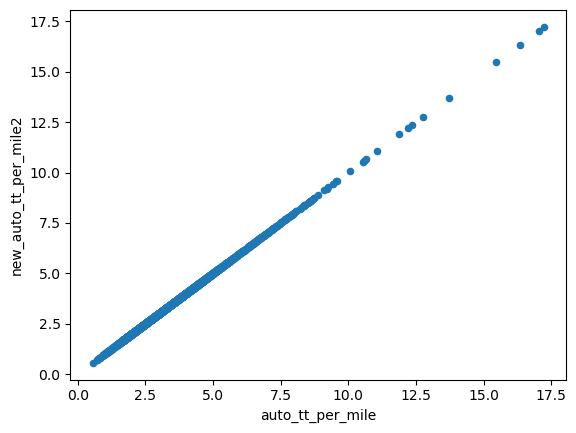

In [18]:
am_merged3.plot('auto_tt_per_mile', 'new_auto_tt_per_mile2', kind='scatter')

In [19]:
am_interpolated_times = am_merged3[['pairs','new_auto_tt2','new_auto_tt_per_mile2']]
am_interpolated_times.to_csv("output/am_interpolated_auto_times.csv")

#### PM Preprocessing

* Format the 2015 OD pair column into strings
* Subset pm 2015 by the OD Pair column, auto travel time, auto travel time per mile and log auto travel time per mile columns
* Merge the track_miles and 2015 AM dataframes together by the od pairs columns

In [20]:
pm2015['odpair_mstn'] = pm2015['odpair_mstn'].astype(str)

In [21]:
subset = pm2015[['odpair_mstn', 'auto_tt', 'auto_tt_per_mile', 'log_auto_tt_per_mile']]
subset

,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile
0,62001,22.180000,2.762142,1.016007
1,62002,31.340000,4.118265,1.415432
2,62068,53.930000,4.132567,1.418899
3,62003,7.040000,2.885246,1.059610
4,62052,44.860001,3.093793,1.129398
...,...,...,...,...
6946,40039,NaN,3.359744,1.211865
6947,40059,NaN,3.359744,1.211865
6948,40055,NaN,3.359744,1.211865
6949,40046,NaN,3.359744,1.211865


In [22]:
pm_merged = track_miles2.merge(subset, left_on='pairs2', right_on='odpair_mstn', how = 'left')

* Filter the rows that are NA in the auto_tt_per_mile column
* Fit a simple linear regression between auto travel time per mile and track miles
* fit the regression to get a new auto travel time column in the dataframe where auto travel time per mile was missing
* Divide the new auto travel time by track miles to get the new auto travel time per mile
* Subset only the required variable names in am_merged2 
* Merge am_merged and am_merged2, then fill the values of auto travel time and auto travel time per mile with the missing values
* Plot the relationship between the old auto travel time and the new travel time
* Export

In [23]:
pm_merged2 = pm_merged[pm_merged['auto_tt_per_mile'].isna()]
pm_merged2['track_miles']

0        0.10
3       11.39
40      22.86
48      21.37
65      11.96
        ...  
8255     7.87
8262    17.06
8268    15.66
8279    22.92
8280     0.10
Name: track_miles, Length: 2003, dtype: float64

In [24]:
Y = pm2015['auto_tt'][pm2015['auto_tt'].notna()]
X = pm2015['track_mile'][pm2015['auto_tt'].notna()]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                auto_tt   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     8429.
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:24:31   Log-Likelihood:                -26407.
No. Observations:                6785   AIC:                         5.282e+04
Df Residuals:                    6783   BIC:                         5.283e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5882      0.288     22.878      0.000       6.024       7.153
track_mile     2.0964      0.023     91.811      0.000       2.052       2.141
==============================================================================
Omnibus:                      111.785   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.716
Skew:                          -0.177   Prob(JB):                     2.31e-37
Kurtosis:                       3.686   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
pm_merged2['new_auto_tt'] = 6.5882	+ 2.0964*pm_merged2['track_miles']
pm_merged2['new_auto_tt_per_mile'] =pm_merged2['new_auto_tt'] / pm_merged2['track_miles']
pm_merged2 = pm_merged2[['pairs2', 'new_auto_tt', 'new_auto_tt_per_mile']]

In [26]:
pm_merged2.head()

,pairs2,new_auto_tt,new_auto_tt_per_mile
0,62062,6.797840,67.978400
3,65062,30.466196,2.674820
40,89062,54.511904,2.384598
48,87062,51.388268,2.404692
65,73062,31.661144,2.647253


In [27]:
pm_merged3 = pm_merged.merge(pm_merged2, on='pairs2', how='left')

In [28]:
pm_merged3['new_auto_tt_per_mile2'] = pm_merged3['auto_tt_per_mile'].fillna(pm_merged3['new_auto_tt_per_mile'])
pm_merged3['new_auto_tt2'] = pm_merged3['auto_tt'].fillna(pm_merged3['new_auto_tt'])
pm_merged3.head()

,ID_x,ID_y,O,D,track_miles,pairs,ID1,ID2,pairs2,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile,new_auto_tt,new_auto_tt_per_mile,new_auto_tt_per_mile2,new_auto_tt2
0,MSTN_062,MSTN_062,Addison Road,Addison Road,0.10,MSTN_0620MSTN_062,62,62,62062,NaN,NaN,NaN,NaN,6.797840,67.97840,67.978400,6.797840
1,MSTN_062,MSTN_001,Anacostia,Addison Road,10.35,MSTN_0010MSTN_062,1,62,1062,1062,13.180000,1.641345,0.495516,NaN,NaN,1.641345,13.180000
2,MSTN_062,MSTN_002,Archives,Addison Road,8.31,MSTN_0020MSTN_062,2,62,2062,2062,13.080000,1.718791,0.541621,NaN,NaN,1.718791,13.080000
3,MSTN_062,MSTN_065,Arlington Cemetery,Addison Road,11.39,MSTN_0650MSTN_062,65,62,65062,NaN,NaN,NaN,NaN,30.466196,2.67482,2.674820,30.466196
4,MSTN_062,MSTN_068,Ballston-MU,Addison Road,14.27,MSTN_0680MSTN_062,68,62,68062,68062,40.669998,3.116475,1.136703,NaN,NaN,3.116475,40.669998


<Axes: xlabel='auto_tt_per_mile', ylabel='new_auto_tt_per_mile2'>

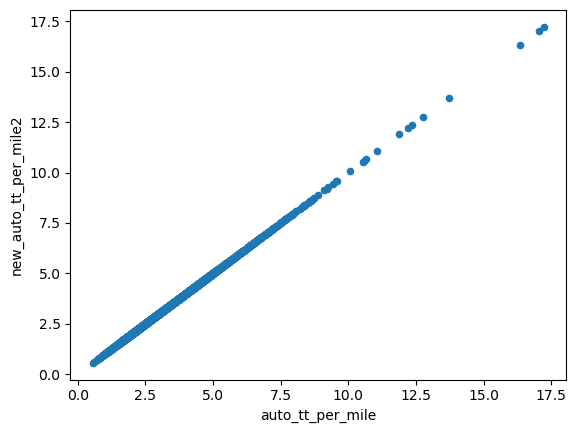

In [29]:
pm_merged3.plot('auto_tt_per_mile', 'new_auto_tt_per_mile2', kind='scatter')

In [30]:
pm_interpolated_times = pm_merged3[['pairs','new_auto_tt2','new_auto_tt_per_mile2']]
pm_interpolated_times.to_csv("output/pm_interpolated_auto_times.csv")

#### Off-Peak Preprocessing

* Format the 2015 OD pair column into strings
* Subset off 2015 by the OD Pair column, auto travel time, auto travel time per mile and log auto travel time per mile columns
* Merge the track_miles and 2015 AM dataframes together by the od pairs columns

In [31]:
off2015['odpair_mstn'] = off2015['odpair_mstn'].astype(str)

In [32]:
subset = off2015[['odpair_mstn', 'auto_tt', 'auto_tt_per_mile', 'log_auto_tt_per_mile']]
subset

,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile
0,31001,8.700000,1.907895,0.646000
1,38001,17.650000,2.322368,0.842588
2,61001,23.490000,3.098945,1.131062
3,74001,7.110000,1.926829,0.655876
4,29001,5.470000,1.178879,0.164564
...,...,...,...,...
6964,20086,18.330000,1.365872,0.311793
6965,77086,13.770000,0.740721,-0.300131
6966,57086,7.670000,0.613110,-0.489212
6967,79086,34.959999,2.033741,0.709877


In [33]:
off_merged = track_miles2.merge(subset, left_on='pairs2', right_on='odpair_mstn', how = 'left')

* Filter the rows that are NA in the auto_tt_per_mile column
* Fit a simple linear regression between auto travel time per mile and track miles
* fit the regression to get a new auto travel time column in the dataframe where auto travel time per mile was missing
* Divide the new auto travel time by track miles to get the new auto travel time per mile
* Subset only the required variable names in am_merged2 
* Merge am_merged and am_merged2, then fill the values of auto travel time and auto travel time per mile with the missing values
* Plot the relationship between the old auto travel time and the new travel time
* Export

In [34]:
off_merged2 = off_merged[off_merged['auto_tt_per_mile'].isna()]
off_merged2['track_miles']

0        0.10
3       11.39
40      22.86
48      21.37
65      11.96
        ...  
8255     7.87
8262    17.06
8268    15.66
8279    22.92
8280     0.10
Name: track_miles, Length: 1986, dtype: float64

In [35]:
Y = off2015['auto_tt'][off2015['auto_tt'].notna()]
X = off2015['track_mile'][off2015['auto_tt'].notna()]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                auto_tt   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                 1.122e+04
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:24:31   Log-Likelihood:                -23502.
No. Observations:                6969   AIC:                         4.701e+04
Df Residuals:                    6967   BIC:                         4.702e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1336      0.169     30.413      0.000       4.803       5.464
track_mile     1.4237      0.013    105.906      0.000       1.397       1.450
==============================================================================
Omnibus:                      395.781   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              679.895
Skew:                          -0.448   Prob(JB):                    2.30e-148
Kurtosis:                       4.240   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
off_merged2['new_auto_tt'] = 5.1336	+ 1.4237*off_merged2['track_miles']
off_merged2['new_auto_tt_per_mile'] =off_merged2['new_auto_tt'] / off_merged2['track_miles']
off_merged2 = off_merged2[['pairs2', 'new_auto_tt', 'new_auto_tt_per_mile']]

In [37]:
off_merged2.head()

,pairs2,new_auto_tt,new_auto_tt_per_mile
0,62062,5.275970,52.759700
3,65062,21.349543,1.874411
40,89062,37.679382,1.648267
48,87062,35.558069,1.663925
65,73062,22.161052,1.852931


In [38]:
off_merged3 = off_merged.merge(off_merged2, on='pairs2', how='left')

In [39]:
off_merged3['new_auto_tt_per_mile2'] = off_merged3['auto_tt_per_mile'].fillna(off_merged3['new_auto_tt_per_mile'])
off_merged3['new_auto_tt2'] = off_merged3['auto_tt'].fillna(off_merged3['new_auto_tt'])
off_merged3

,ID_x,ID_y,O,D,track_miles,pairs,ID1,ID2,pairs2,odpair_mstn,auto_tt,auto_tt_per_mile,log_auto_tt_per_mile,new_auto_tt,new_auto_tt_per_mile,new_auto_tt_per_mile2,new_auto_tt2
0,MSTN_062,MSTN_062,Addison Road,Addison Road,0.10,MSTN_0620MSTN_062,62,62,62062,NaN,NaN,NaN,NaN,5.275970,52.759700,52.759700,5.275970
1,MSTN_062,MSTN_001,Anacostia,Addison Road,10.35,MSTN_0010MSTN_062,1,62,1062,1062,13.100000,1.265700,0.235626,NaN,NaN,1.265700,13.100000
2,MSTN_062,MSTN_002,Archives,Addison Road,8.31,MSTN_0020MSTN_062,2,62,2062,2062,13.230000,1.592058,0.465027,NaN,NaN,1.592058,13.230000
3,MSTN_062,MSTN_065,Arlington Cemetery,Addison Road,11.39,MSTN_0650MSTN_062,65,62,65062,NaN,NaN,NaN,NaN,21.349543,1.874411,1.874411,21.349543
4,MSTN_062,MSTN_068,Ballston-MU,Addison Road,14.27,MSTN_0680MSTN_062,68,62,68062,68062,33.349998,2.337071,0.848898,NaN,NaN,2.337071,33.349998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276,MSTN_040,MSTN_059,West Falls Church,Woodley Park,12.38,MSTN_0590MSTN_040,59,40,59040,59040,29.930000,2.417609,0.882779,NaN,NaN,2.417609,29.930000
8277,MSTN_040,MSTN_055,West Hyattsville,Woodley Park,9.74,MSTN_0550MSTN_040,55,40,55040,55040,13.460000,1.381930,0.323481,NaN,NaN,1.381930,13.460000
8278,MSTN_040,MSTN_046,Wheaton,Woodley Park,14.38,MSTN_0460MSTN_040,46,40,46040,46040,18.770000,1.305285,0.266421,NaN,NaN,1.305285,18.770000
8279,MSTN_040,MSTN_091,Wiehle,Woodley Park,22.92,MSTN_0910MSTN_040,91,40,91040,NaN,NaN,NaN,NaN,37.764804,1.647679,1.647679,37.764804


<Axes: xlabel='auto_tt_per_mile', ylabel='new_auto_tt_per_mile2'>

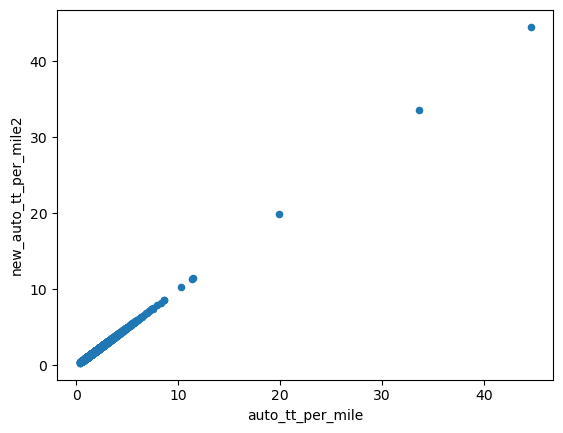

In [40]:
off_merged3.plot('auto_tt_per_mile', 'new_auto_tt_per_mile2', kind='scatter')

In [41]:
off_interpolated_times = off_merged3[['pairs','new_auto_tt2','new_auto_tt_per_mile2']]
off_interpolated_times.to_csv("output/off_interpolated_auto_times.csv")